In [ ]:
import cv2
import torch
import dlib
import numpy as np

def extract_lip_and_face_tensors(video_path, fps_target=5, image_size=(224, 224), mouth_size=(224, 224)):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if fps <= 0 or total_frames <= 0:
        print(f"[SKIP] ❌ Tidak bisa membaca video: {video_path}")
        cap.release()
        return None, None

    duration_sec = total_frames / fps
    expected_min_frame_count = int(duration_sec * fps_target)
    frame_interval = max(int(round(fps / fps_target)), 1)

    lip_frames = []
    face_frames = []
    last_face_tensor = None
    last_lip_tensor = None

    idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval != 0:
            idx += 1
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        if faces:
            face = faces[0]
            x1 = max(face.left(), 0)
            y1 = max(face.top(), 0)
            x2 = min(face.right(), frame.shape[1])
            y2 = min(face.bottom(), frame.shape[0])
            face_crop = frame[y1:y2, x1:x2]
            face_resized = cv2.resize(face_crop, image_size)
            face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
            face_tensor = torch.tensor(face_rgb).permute(2, 0, 1).float() / 255.0
            face_frames.append(face_tensor)
            last_face_tensor = face_tensor

            shape = predictor(gray, face)
            coords = np.array([(pt.x, pt.y) for pt in shape.parts()])
            lip_coords = coords[48:68]  # bibir
            x, y, w, h = cv2.boundingRect(lip_coords)
            margin = 10
            x1_lip = max(x - margin, 0)
            y1_lip = max(y - margin, 0)
            x2_lip = min(x + w + margin, frame.shape[1])
            y2_lip = min(y + h + margin, frame.shape[0])

            mouth_crop = frame[y1_lip:y2_lip, x1_lip:x2_lip]
            mouth_resized = cv2.resize(mouth_crop, mouth_size)
            mouth_rgb = cv2.cvtColor(mouth_resized, cv2.COLOR_BGR2RGB)
            mouth_tensor = torch.tensor(mouth_rgb).permute(2, 0, 1).float() / 255.0
            lip_frames.append(mouth_tensor)
            last_lip_tensor = mouth_tensor
        else:
            # Interpolasi jika wajah atau bibir tidak terdeteksi
            if last_face_tensor is not None:
                face_frames.append(last_face_tensor.clone())
            if last_lip_tensor is not None:
                lip_frames.append(last_lip_tensor.clone())

        idx += 1

    cap.release()
    
    if len(face_frames) < expected_min_frame_count:
        print(f"[SKIP] {video_path}: hanya {len(face_frames)} frame wajah < {expected_min_frame_count} seharusnya ({duration_sec:.2f}s)")
        return None

    if len(lip_frames) < expected_min_frame_count:
        print(f"[SKIP] {video_path}: hanya {len(lip_frames)} frame bibir < {expected_min_frame_count} seharusnya ({duration_sec:.2f}s)")
        return None

    lip_tensor = torch.stack(lip_frames)
    face_tensor = torch.stack(face_frames)

    return lip_tensor, face_tensor


def plot_tensors(face_tensor, lip_tensor):
    import matplotlib.pyplot as plt
    
    num_frames_to_show = min(5, face_tensor.size(0))
    fig, axes = plt.subplots(1, num_frames_to_show, figsize=(15, 5))
    
    for i in range(num_frames_to_show):
        img = face_tensor[i].permute(1, 2, 0).numpy()
        img = (img * 255).astype('uint8')

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {i+1}")

    plt.show()
    
    num_frames_to_show = min(5, lip_tensor.size(0))
    fig, axes = plt.subplots(1, num_frames_to_show, figsize=(15, 5))
    
    for i in range(num_frames_to_show):
        img = lip_tensor[i].permute(1, 2, 0).numpy()
        img = (img * 255).astype('uint8')

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {i+1}")

    plt.show()

In [ ]:
def extract_mel_spectrogram(audio_path, target_frames, sr_target=16000, n_mels=128):
    import librosa
    import librosa.display
    import numpy as np
    import torch

    y, sr = librosa.load(audio_path, sr=sr_target)
    duration = target_frames / 5  # 5 fps
    max_len = int(duration * sr_target)

    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)), 'constant')

    # STFT → Mel Spectrogram
    S = librosa.stft(y, n_fft=2048, hop_length=512)
    S_power = np.abs(S) ** 2
    mel = librosa.feature.melspectrogram(S=S_power, sr=sr_target, n_mels=n_mels)

    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_tensor = torch.tensor(mel_db).unsqueeze(0)
    
    return mel_tensor

def interpolate_mel(mel_tensor, target_T):
    import torch
    import torch.nn.functional as F
    """
    Interpolasi mel tensor agar jumlah frame waktu (T) sesuai dengan visual.
    Input  : mel_tensor shape (1, F, T_original)
    Output : mel_tensor shape (1, F, target_T)
    """
    mel_tensor = mel_tensor.unsqueeze(0)
    mel_resized = F.interpolate(mel_tensor, size=(mel_tensor.shape[2], target_T), mode='bilinear', align_corners=False)

    return mel_resized.squeeze(0)

def plot_mel(mel_tensor):
    import matplotlib.pyplot as plt
    
    if isinstance(mel_tensor, torch.Tensor):
        mel_tensor = mel_tensor.squeeze().numpy()

    plt.figure(figsize=(8, 4))
    plt.imshow(mel_tensor[:, :50], aspect='auto', origin='lower', cmap='magma')
    plt.title("Mel-Spectrogram (Normalized)")
    plt.xlabel("Time Frame")
    plt.ylabel("Mel Filterbank")
    plt.colorbar(label="Normalized Power (0–1)")
    plt.tight_layout()
    plt.show()

In [ ]:
def process_and_save(video_path, audio_path, label, save_path):
    tensors = extract_lip_and_face_tensors(video_path)
    
    if tensors is None:
        print(f"[SKIP] {video_path} tidak valid.")
        return
    
    lip_tensor, face_tensor = tensors
    
    # plot_tensors(face_tensor, lip_tensor)

    mel_tensor = extract_mel_spectrogram(audio_path, target_frames=len(lip_tensor))
    mel_tensor = interpolate_mel(mel_tensor, target_T=len(lip_tensor))
    
    # print(face_tensor.shape)
    # print(lip_tensor.shape)
    # print(mel_tensor.shape)

    data = {
        'face_frames':face_tensor,
        'lip_frames': lip_tensor,
        'audio': mel_tensor,
        'label': label
    }
    torch.save(data, save_path)


In [ ]:
from tqdm import tqdm
import os
import json

video_dir = "Dataset/"
audio_dir = "Dataset_Skripsi/audios_enhanced/"
metadata_path = "Dataset/metadata.json"
save_dir = "Dataset_Skripsi/Multimodal_pt_gabungan"
os.makedirs(save_dir, exist_ok=True)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 1
}

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

for fname, meta in tqdm(metadata.items()):
    label_name = meta.get("label")
    if label_name not in label_map:
        continue
    
    video_path = os.path.join(video_dir, fname)
    audio_path = os.path.join(audio_dir, fname.replace(".mp4", ".wav"))
    label = label_map[label_name]

    if label == -1 or not os.path.exists(audio_path):
        continue

    save_path = os.path.join(save_dir, fname.replace(".mp4", ".pt"))
    process_and_save(video_path, audio_path, label, save_path)


100%|██████████| 500/500 [1:33:34<00:00, 11.23s/it]


In [4]:
video_dir = "Dataset/testing"
audio_dir = "Dataset_Skripsi/testing CNN-BiLSTM/audios_enhanced/"
metadata_path = "Dataset/testing/metadata.json"
save_dir = "Dataset_Skripsi/testing CNN-BiLSTM/Multimodal_pt_gabungan"
os.makedirs(save_dir, exist_ok=True)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 1
}

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

for fname, meta in tqdm(metadata.items()):
    label_name = meta.get("label")
    if label_name not in label_map:
        continue
    
    video_path = os.path.join(video_dir, fname)
    audio_path = os.path.join(audio_dir, fname.replace(".mp4", ".wav"))
    label = label_map[label_name]

    if label == -1 or not os.path.exists(audio_path):
        continue

    save_path = os.path.join(save_dir, fname.replace(".mp4", ".pt"))
    process_and_save(video_path, audio_path, label, save_path)


  1%|▏         | 2/150 [00:21<24:13,  9.82s/it]

[SKIP] Dataset/testing\adfzvplbky.mp4 terlalu sedikit frame bibir.


 23%|██▎       | 35/150 [07:17<22:44, 11.87s/it]

[SKIP] Dataset/testing\vddzflpeat.mp4 terlalu sedikit frame bibir.


100%|██████████| 150/150 [33:49<00:00, 13.53s/it]


In [6]:
from tqdm import tqdm
import os
import json

video_dir = "Dataset/"
audio_dir = "Dataset_Skripsi/audios_enhanced/"
metadata_path = "Dataset/metadata.json"
save_dir = "Dataset_Skripsi/Multimodal_pt_gabungan_3Label"
os.makedirs(save_dir, exist_ok=True)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

for fname, meta in tqdm(metadata.items()):
    label_name = meta.get("label")
    if label_name not in label_map:
        continue
    
    video_path = os.path.join(video_dir, fname)
    audio_path = os.path.join(audio_dir, fname.replace(".mp4", ".wav"))
    label = label_map[label_name]

    if label == -1 or not os.path.exists(audio_path):
        continue

    save_path = os.path.join(save_dir, fname.replace(".mp4", ".pt"))
    process_and_save(video_path, audio_path, label, save_path)


  0%|          | 0/500 [00:00<?, ?it/s]

  8%|▊         | 41/500 [13:14<1:27:44, 11.47s/it]

[SKIP] Dataset/fojjdrqzkz.mp4: hanya 46 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/fojjdrqzkz.mp4 tidak valid.


 22%|██▏       | 108/500 [25:08<1:08:55, 10.55s/it]

[SKIP] Dataset/exoiljxgnb.mp4: hanya 49 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/exoiljxgnb.mp4 tidak valid.


 51%|█████     | 255/500 [51:57<1:05:56, 16.15s/it]

[SKIP] Dataset/lkypoiafbx.mp4: hanya 49 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/lkypoiafbx.mp4 tidak valid.


 51%|█████     | 256/500 [52:13<1:05:14, 16.04s/it]

[SKIP] Dataset/onnpghvisw.mp4: hanya 49 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/onnpghvisw.mp4 tidak valid.


 69%|██████▉   | 346/500 [1:13:49<26:41, 10.40s/it]

[SKIP] Dataset/wnlamfqjaj_lipsync.mp4: hanya 44 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/wnlamfqjaj_lipsync.mp4 tidak valid.


 83%|████████▎ | 416/500 [1:26:06<14:28, 10.34s/it]

[SKIP] Dataset/ieazyslhjp_lipsync.mp4: hanya 49 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/ieazyslhjp_lipsync.mp4 tidak valid.


 93%|█████████▎| 463/500 [1:33:20<06:25, 10.41s/it]

[SKIP] Dataset/lkypoiafbx_lipsync.mp4: hanya 49 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/lkypoiafbx_lipsync.mp4 tidak valid.


100%|██████████| 500/500 [1:39:47<00:00, 11.97s/it]


In [7]:
from tqdm import tqdm
import os
import json

video_dir = "Dataset/testing"
audio_dir = "Dataset_Skripsi/testing CNN-BiLSTM/audios_enhanced/"
metadata_path = "Dataset/testing/metadata.json"
save_dir = "Dataset_Skripsi/testing CNN-BiLSTM/Multimodal_pt_gabungan_3Label"
os.makedirs(save_dir, exist_ok=True)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

for fname, meta in tqdm(metadata.items()):
    label_name = meta.get("label")
    if label_name not in label_map:
        continue
    
    video_path = os.path.join(video_dir, fname)
    audio_path = os.path.join(audio_dir, fname.replace(".mp4", ".wav"))
    label = label_map[label_name]

    if label == -1 or not os.path.exists(audio_path):
        continue

    save_path = os.path.join(save_dir, fname.replace(".mp4", ".pt"))
    process_and_save(video_path, audio_path, label, save_path)


  1%|▏         | 2/150 [00:12<14:43,  5.97s/it]

[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 40 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\adfzvplbky.mp4 tidak valid.


  4%|▍         | 6/150 [00:44<19:32,  8.14s/it]

[SKIP] Dataset/testing\evyqbkbsiv.mp4: hanya 42 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/testing\evyqbkbsiv.mp4 tidak valid.


 12%|█▏        | 18/150 [02:25<18:31,  8.42s/it]

[SKIP] Dataset/testing\ohmkmcfxul.mp4: hanya 49 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/testing\ohmkmcfxul.mp4 tidak valid.


 15%|█▌        | 23/150 [02:59<13:35,  6.42s/it]

[SKIP] Dataset/testing\tmpzveqsou.mp4: hanya 0 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\tmpzveqsou.mp4 tidak valid.


 23%|██▎       | 35/150 [04:52<15:42,  8.19s/it]

[SKIP] Dataset/testing\vddzflpeat.mp4: hanya 42 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\vddzflpeat.mp4 tidak valid.


 25%|██▍       | 37/150 [05:13<17:46,  9.44s/it]

[SKIP] Dataset/testing\ahencqpiin.mp4: hanya 44 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/testing\ahencqpiin.mp4 tidak valid.


 40%|████      | 60/150 [09:15<15:39, 10.44s/it]

[SKIP] Dataset/testing\vyoozsirec.mp4: hanya 48 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/testing\vyoozsirec.mp4 tidak valid.


 41%|████      | 61/150 [09:25<15:23, 10.37s/it]

[SKIP] Dataset/testing\pupjadwkax.mp4: hanya 48 frame wajah < 50 seharusnya (10.01s)
[SKIP] Dataset/testing\pupjadwkax.mp4 tidak valid.


 69%|██████▉   | 104/150 [16:51<06:44,  8.80s/it]

[SKIP] Dataset/testing\dwmsebyypl_lipsync.mp4: hanya 46 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\dwmsebyypl_lipsync.mp4 tidak valid.


 73%|███████▎  | 109/150 [17:33<05:06,  7.48s/it]

[SKIP] Dataset/testing\tmpzveqsou_lipsync.mp4: hanya 0 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\tmpzveqsou_lipsync.mp4 tidak valid.


 81%|████████  | 121/150 [19:27<04:01,  8.31s/it]

[SKIP] Dataset/testing\vddzflpeat_lipsync.mp4: hanya 47 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\vddzflpeat_lipsync.mp4 tidak valid.


100%|██████████| 150/150 [24:35<00:00,  9.83s/it]


  1%|          | 1/150 [00:09<23:09,  9.33s/it]

[SKIP] Dataset/testing\accfrqkrni.mp4: hanya 48 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\accfrqkrni.mp4 tidak valid.


  1%|▏         | 2/150 [00:15<18:39,  7.57s/it]

[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 1 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\adfzvplbky.mp4 tidak valid.


  2%|▏         | 3/150 [00:23<18:55,  7.72s/it]

[SKIP] Dataset/testing\adrqlckutl.mp4: hanya 26 frame wajah < 50 seharusnya (10.03s)
[SKIP] Dataset/testing\adrqlckutl.mp4 tidak valid.


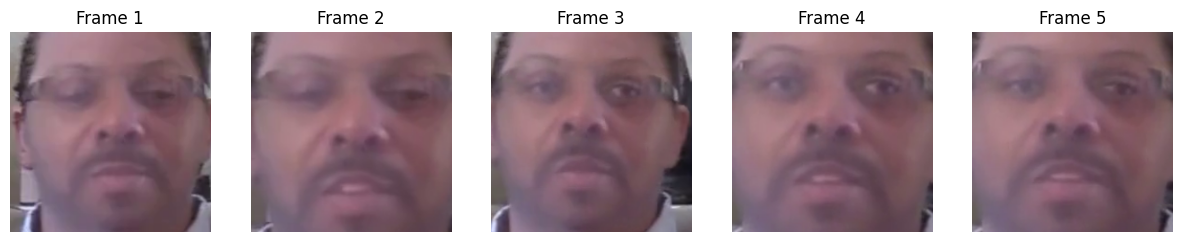

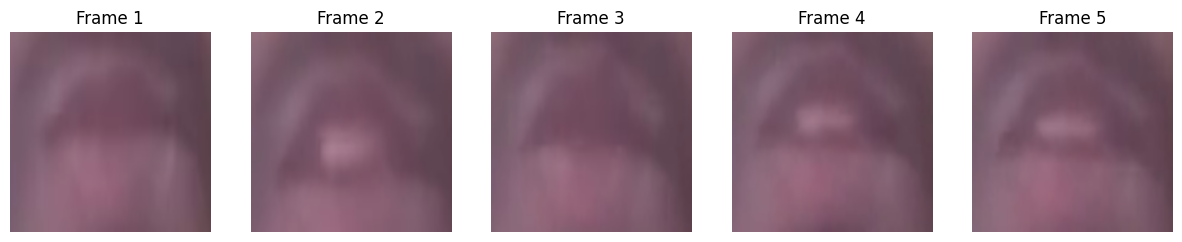

  3%|▎         | 4/150 [00:53<32:18, 13.28s/it]


KeyboardInterrupt: 

In [8]:
from tqdm import tqdm
import os
import json

video_dir = "Dataset/testing"
audio_dir = "Dataset_Skripsi/testing CNN-BiLSTM/audios_enhanced/"
metadata_path = "Dataset/testing/metadata.json"
save_dir = "Dataset_Skripsi/testing CNN-BiLSTM/Multimodal_pt_gabungan_3Label"
os.makedirs(save_dir, exist_ok=True)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

for fname, meta in tqdm(metadata.items()):
    label_name = meta.get("label")
    if label_name not in label_map:
        continue
    
    video_path = os.path.join(video_dir, fname)
    audio_path = os.path.join(audio_dir, fname.replace(".mp4", ".wav"))
    label = label_map[label_name]

    if label == -1 or not os.path.exists(audio_path):
        continue

    save_path = os.path.join(save_dir, fname.replace(".mp4", ".pt"))
    process_and_save(video_path, audio_path, label, save_path)
